
We will implement a segmentation approach based on thresholding and carry out a detailed experimentation process to select the most effective detection method. This involves preprocessing the image channels, building on the techniques explored in the first part of the project and applying intensity transformations.

After preprocessing, we will apply four different thresholding strategies. Based on a qualitative assessment, we will choose the most promising combinations of preprocessing and thresholding techniques to process the validation dataset.


## Part 1: Thresholding

As in the first stage of the project, we will apply thresholding to our images to obtain binary masks. However, what will vary this time is the method used to determine the thresholds. As we know, there are several thresholding techniques, including Otsu’s method, percentile-based thresholding, and arbitrary thresholding.

In this case, we will only implement functions for percentile-based thresholding and arbitrary thresholding.

In [343]:
# Importación de las librerías necesarias.
# Si necesita usar más librerías agreguelas en este espacio para mantener su código organizado.
import os
import glob 
import numpy as np
import json
import pandas as pd
!pip install tabulate

import cv2
from skimage import io
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
import requests
from PIL import Image
from skimage.exposure import match_histograms
import glob
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_recall_curve, average_precision_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, jaccard_score, precision_recall_curve, average_precision_score
from sklearn.utils.multiclass import type_of_target

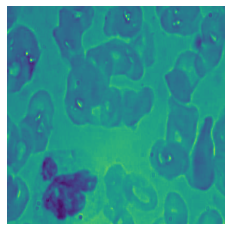

In [344]:

import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# Subir la imagen 
path = os.path.join(os.getcwd(), "data_mp1", "BCCD", "train", "BloodImage_00001_jpg.rf.ee79407f4ce4abd4fc56f42c176d324b.jpg")

# Usar cv2 para leer la imagen
image = cv2.imread(path)

# Extraer el canal rojo
bw_img= image[:, :, 2]  

#Mostrar imagen solo en un canal 
plt.imshow(bw_img)
plt.axis("off")
plt.show()


### Part 1.1: Percentiles

We will begin by implementing percentile-based thresholding. For this, you can use the function you created in the previous stage of the project.


In [345]:
from skimage.io import imread  # Importar imread correctamente
import numpy as np

def umbralizacion_percentile(im, percentile):
    """ Esta función umbraliza una imagen en escala de grises con un umbral por percentil.

    Args:
        im (numpy.ndarray): Imagen a umbralizar.
        percentile (float): Percentil a utilizar para realizar la umbralización.

    Returns:
        (numpy.ndarray): Imagen umbralizada.
    """
    assert len(im.shape) < 3, "La imagen debe estar en escala de grises"

    # Obtener el umbral basado en el percentil
    threshold = np.percentile(im, percentile)

    # Generar imagen binaria con valores 0 y 1
    percentilebin_img = (im < threshold).astype(np.uint8)

    # Depuración: Verificar valores clave
    print(f"Tipo de imagen: {im.dtype}, Rango: [{im.min()}, {im.max()}]")
    print(f"Umbral utilizado: {threshold}")
    print(f"Píxeles con valor 1 después de umbralización: {np.sum(percentilebin_img)}")
    print(f"Suma de píxeles después de umbralización: {np.sum(percentilebin_img)}")  # Debe ser 8578

    return percentilebin_img


Tipo de imagen: uint8, Rango: [124, 255]
Umbral utilizado: 157.0
Píxeles con valor 1 después de umbralización: 4922
Suma de píxeles después de umbralización: 4922


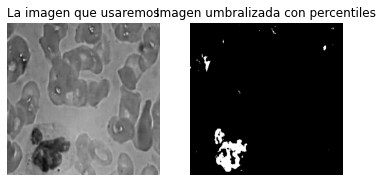

In [346]:
percentilebin_img=umbralizacion_percentile(bw_img,3)

fig,ax=plt.subplots(1, 2)
ax[0].imshow(bw_img,cmap='gray')
ax[0].set_title('La imagen que usaremos')
ax[0].axis('off')
ax[1].imshow(percentilebin_img,cmap='gray')
ax[1].set_title('Imagen umbralizada con percentiles')
ax[1].axis('off')
plt.show()

assert np.sum(percentilebin_img)<416*416/2, 'Usted umbralizó la imagen al reves'
assert np.isclose(np.sum(percentilebin_img),4933) or np.isclose(np.sum(percentilebin_img),4922), 'El umbral del percentile es erroneo'

### Part 1.2: Arbitrary Thresholds

Finally, thresholds can be selected arbitrarily using the available information. Here, we can rely heavily on the intensity histogram of the image to determine the appropriate threshold, as well as the condition (greater than or less than).

Create a function that takes an image and a threshold value as input, and returns a thresholded image.


In [347]:
def umbralizacion_arbitrario(im,umbral):
    """ Esta función umbraliza una imagen en escala de grises con un umbral arbitrario.

    Args:
        im (numpy.ndarray): Imagen a umbralizar.
        umbral (int): umbral a utilizar

    Returns:
        (numpy.ndarray): Imagen umbralizada.
    
    """
    assert len(im.shape) < 3, "La imagen debe estar en escala de grises"
    arbitrarybin_img = (im < umbral).astype(np.uint8)

    return arbitrarybin_img

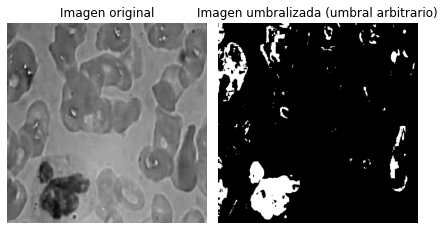

In [348]:
arbitrarybin_img=umbralizacion_arbitrario(bw_img,170)

fig,ax=plt.subplots(1,2)
ax[0].imshow(bw_img,cmap='gray')
ax[0].set_title('Imagen original')
ax[0].axis('off')
ax[1].imshow(arbitrarybin_img,cmap='gray')
ax[1].set_title('Imagen umbralizada (umbral arbitrario)')
ax[1].axis('off')
plt.tight_layout()
plt.show()

assert np.sum(arbitrarybin_img)<416*416/2, 'Usted umbralizó la imagen al reves'
assert np.isclose(np.sum(arbitrarybin_img),14952) or np.isclose(np.sum(arbitrarybin_img),14950), 'La umbralización fue erroneo'

## Part 2: Predictions

Now that we have a thresholding method, we will generate a `.json` file containing the predictions.

### Part 2.1: Detection Using the Largest Connected Component

The first step is to build a function that replicates the process from the previous stage, where—given a binary mask—we computed the bounding box coordinates.

This time, we will improve the method by adding a threshold parameter. This threshold will help define a minimum size for white blood cells. In the previous stage, our method did not account for the possibility of images without any white blood cells, which led the algorithm to always attempt a detection—even when none were present. By introducing this size threshold, we can filter out smaller connected components. Although this strategy is not 100% accurate, it improves the robustness of our algorithm.


In [349]:
def deteccion(mask,umbral):
    """ Esta función toma una imagen ya umbralizada y da como resultado la detección correspondiente.

    Args:
        mask (numpy.ndarray): Imagen donde se quiere detectar el glóbulo blanco.
        umbral (int): Área mínima que debe ocupar un glóbulo blanco para ser considerado como tal.
        Si el área del elemento conexo más grande no supera el umbral entonces retornaremos None en X, Y, W, H
        
    Returns:
        (int): coordenada X, (int): coordenada Y, (int): ancho de la caja (W), (int): alto de la caja (H)
    """
    #Encontrar conexos 
    conexos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not conexos:
        return None 
    # Seleccionar el contorno con el área más grande
    conexo_g = max(conexos, key=cv2.contourArea)
    area_mayor = cv2.contourArea(conexo_g)
    #Comprobar para retornar
    if area_mayor < umbral:
        return None
    
    # Detección correspondiente
    X, Y, W, H = cv2.boundingRect(conexo_g)
    
    return  X, Y, W, H


In [350]:
img_1 = io.imread(glob.glob(os.path.join('.','data_mp1','BCCD','train','*.jpg'))[0])[:,:,0]
percentilebin_img_1 = umbralizacion_percentile(img_1, 3)

assert deteccion(percentilebin_img, 1000) == (69, 319, 87, 89), 'La detección no fue correcta'

img_2 = io.imread(glob.glob(os.path.join('.','data_mp1','BCCD','train','*.jpg'))[17])[:,:,0]
percentilebin_img_2 = umbralizacion_percentile(img_2, 3)

assert deteccion(percentilebin_img_2, 1000) == (178, 11, 72, 118), 'La detección no fue correcta'

Tipo de imagen: uint8, Rango: [125, 255]
Umbral utilizado: 157.0
Píxeles con valor 1 después de umbralización: 4933
Suma de píxeles después de umbralización: 4933
Tipo de imagen: uint8, Rango: [96, 242]
Umbral utilizado: 141.0
Píxeles con valor 1 después de umbralización: 5110
Suma de píxeles después de umbralización: 5110


In [351]:
import numpy as np

def diccionario_prediccion(image, image_id, segmentation_method, dato=None):
    """ Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna un diccionario con la predicción de la anotación.

    Args:
        image (numpy.ndarray):  Imagen de entrada de 1 canal.
        image_id (int): Identificador de la imagen.
        segmentation_method (str): Puede ser "percentile" o "arbitrario".
        dato (int or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parámetro será el umbral o el percentil.
        
    Returns:
        dict: Diccionario con llaves: images_id, category_id, bbox, score. 
              Corresponde a la predicción del algoritmo sobre dónde está el glóbulo blanco.
    """
    # Para hallar método de segmentación
    if segmentation_method == "arbitrario":
        metodo_segmentacion = umbralizacion_arbitrario
    elif segmentation_method == "percentile":
        metodo_segmentacion = umbralizacion_percentile
    else:
        raise ValueError("Método de segmentación no válido. Use 'arbitrario' o 'percentile'.")

    # Hallar máscara binaria
    mask = metodo_segmentacion(image, dato)
    
    # Detección
    resultado_bbox = deteccion(mask, 1000)
    
    if resultado_bbox is None:
        return {
            "image_id": image_id,
            "category_id": 1,  # Se asume una única categoría
            "bbox": [0, 0, 0, 0],
            "score": 0.0
        }
        
    X, Y, W, H = resultado_bbox
    
    if W == 0 or H == 0:
        score = 0.0
    else:
        area_deteccion = np.sum(mask[Y:Y+H, X:X+W] > 0)
        score = area_deteccion / (W * H)
        score = max(0.0, min(1.0, score))

    dict_deteccion = {
        "image_id": image_id,
        "category_id": 1,  # Se asume una única categoría
        "bbox": [int(X), int(Y), int(W), int(H)],  # Convertir bbox a enteros
        "score": float(score)  # Convertir score a flotante
    }
    
    return dict_deteccion


Tipo de imagen: uint8, Rango: [90, 255]
Umbral utilizado: 144.0
Píxeles con valor 1 después de umbralización: 4992
Suma de píxeles después de umbralización: 4992
Tipo de imagen: uint8, Rango: [90, 255]
Umbral utilizado: 144.0
Píxeles con valor 1 después de umbralización: 4992
Suma de píxeles después de umbralización: 4992


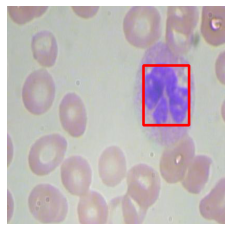

In [352]:
with open(os.path.join('data_mp1','BCCD','train','_annotations.coco.json'),'rb') as f:
    anots=json.load(f)

im_name=anots['images'][0]['file_name']
id_image=anots['images'][0]['id']
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
dict_predict=diccionario_prediccion(image[:,:,0],id_image,'percentile', 3)

assert type(dict_predict)==dict, 'El dict_predict deberia ser un diccionario'
assert 'image_id' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "image_id"'
assert 'category_id' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "category_id"'
assert 'bbox' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "bbox"'
assert 'score' in dict_predict.keys(), 'El diccionario de detección no tiene la llave "score"'
assert dict_predict['score'] >=0 and dict_predict['score'] <=1, 'El score debe estar entre 0 y 1'
assert len(dict_predict['bbox'])==4, 'La bbox deberia tener 4 valores'

X,Y,W,H= dict_predict['bbox']
mask=umbralizacion_percentile(image[:,:,0], 3)
assert np.isclose(np.sum(mask[Y:Y+H,X:X+W])/(H*W),dict_predict['score']), 'El score está mal calculado, puede que ester usando las filas como columnas y viseversa'
assert np.isclose(W, 87) and (np.isclose(H, 114) or np.isclose(H,116)), 'El tamaño de la caja es erroneo'
assert np.isclose(X, 260, 0.01), 'Hay un error en la detección'
assert np.isclose(Y, 113, 0.01) or np.isclose(Y, 111, 0.01), 'Hay un error en la detección'

plt.imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
plt.axis('off')
plt.show()

In [353]:
def prediccion_total(fold,segmentation_method,dato=None):
    """ Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna un diccionario con la predicción de la anotación.

    Args:
        fold (str): Puede ser "train", "valid" o "test"
        segmentation_method (str): Puede ser "percentile" o "arbitrario"
        dato (int or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parametró será el umbral o el percentil
        
    Returns:
        (list): Lista de diccionarios. Los diccionarios son los generados por la función diccionario_prediccion.
    """
    list_predict = []

    # Ruta correcta del archivo JSON de anotaciones
    ruta_anotaciones = os.path.join(os.getcwd(), "data_mp1", "BCCD", fold, "_annotations.coco.json")

    # Verificar si el archivo JSON de anotaciones existe
    if not os.path.exists(ruta_anotaciones):
        print(f"Error: No se encontró el archivo de anotaciones en {ruta_anotaciones}")
        return []

    # Cargar el archivo JSON con las anotaciones
    with open(ruta_anotaciones, "r") as f:
        anotaciones = json.load(f)

    # Verificar que hay imágenes en el JSON
    if "images" not in anotaciones or not anotaciones["images"]:
        print("Error: El archivo de anotaciones no contiene imágenes.")
        return []

    # Filtrar imágenes del fold
    imagenes_fold = anotaciones["images"]
    
    # Depuración: Ver cuántas imágenes hay
    print(f"Se encontraron {len(imagenes_fold)} imágenes en el fold '{fold}'.")

    # Verificar si hay imágenes en el fold
    if not imagenes_fold:
        print(f"Advertencia: No se encontraron imágenes para el fold '{fold}'.")
        return []

    # Ruta de la carpeta de imágenes
    ruta_imagenes = os.path.join(os.getcwd(), "data_mp1", "BCCD", fold)

    for img_info in imagenes_fold:
        image_id = img_info["id"]
        nombre_imagen = img_info["file_name"]

        # Cargar la imagen en escala de grises
        ruta_completa = os.path.join(ruta_imagenes, nombre_imagen)
        image = cv2.imread(ruta_completa, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Advertencia: No se pudo cargar la imagen {nombre_imagen}. Se omitirá.")
            continue  # Omitir imagen no encontrada

        # Obtener la predicción con la función diccionario_prediccion
        prediccion = diccionario_prediccion(image, image_id, segmentation_method, dato)
        
        # Depuración: Verificar el resultado de la predicción
        if prediccion is None:
            print(f"Error: La función diccionario_prediccion devolvió None para {nombre_imagen}.")
            continue
        
        list_predict.append(prediccion)

    # Depuración: Verificar si hay predicciones en la lista
    print(f"Se generaron {len(list_predict)} predicciones.")

    return list_predict

In [354]:
list_predict=prediccion_total('train','percentile',3)

Se encontraron 224 imágenes en el fold 'train'.
Tipo de imagen: uint8, Rango: [94, 247]
Umbral utilizado: 130.0
Píxeles con valor 1 después de umbralización: 5143
Suma de píxeles después de umbralización: 5143
Tipo de imagen: uint8, Rango: [103, 242]
Umbral utilizado: 136.0
Píxeles con valor 1 después de umbralización: 5158
Suma de píxeles después de umbralización: 5158
Tipo de imagen: uint8, Rango: [101, 251]
Umbral utilizado: 134.0
Píxeles con valor 1 después de umbralización: 5124
Suma de píxeles después de umbralización: 5124
Tipo de imagen: uint8, Rango: [119, 238]
Umbral utilizado: 147.0
Píxeles con valor 1 después de umbralización: 5116
Suma de píxeles después de umbralización: 5116
Tipo de imagen: uint8, Rango: [118, 243]
Umbral utilizado: 144.0
Píxeles con valor 1 después de umbralización: 4961
Suma de píxeles después de umbralización: 4961
Tipo de imagen: uint8, Rango: [109, 239]
Umbral utilizado: 129.0
Píxeles con valor 1 después de umbralización: 4826
Suma de píxeles despué

Píxeles con valor 1 después de umbralización: 5069
Suma de píxeles después de umbralización: 5069
Tipo de imagen: uint8, Rango: [82, 251]
Umbral utilizado: 135.0
Píxeles con valor 1 después de umbralización: 5186
Suma de píxeles después de umbralización: 5186
Tipo de imagen: uint8, Rango: [118, 233]
Umbral utilizado: 144.0
Píxeles con valor 1 después de umbralización: 5043
Suma de píxeles después de umbralización: 5043
Tipo de imagen: uint8, Rango: [109, 222]
Umbral utilizado: 143.0
Píxeles con valor 1 después de umbralización: 5093
Suma de píxeles después de umbralización: 5093
Tipo de imagen: uint8, Rango: [118, 235]
Umbral utilizado: 139.0
Píxeles con valor 1 después de umbralización: 5064
Suma de píxeles después de umbralización: 5064
Tipo de imagen: uint8, Rango: [101, 237]
Umbral utilizado: 125.0
Píxeles con valor 1 después de umbralización: 5141
Suma de píxeles después de umbralización: 5141
Tipo de imagen: uint8, Rango: [102, 236]
Umbral utilizado: 132.0
Píxeles con valor 1 des

Píxeles con valor 1 después de umbralización: 5101
Suma de píxeles después de umbralización: 5101
Tipo de imagen: uint8, Rango: [98, 253]
Umbral utilizado: 132.0
Píxeles con valor 1 después de umbralización: 5093
Suma de píxeles después de umbralización: 5093
Tipo de imagen: uint8, Rango: [108, 243]
Umbral utilizado: 131.0
Píxeles con valor 1 después de umbralización: 4930
Suma de píxeles después de umbralización: 4930
Tipo de imagen: uint8, Rango: [119, 231]
Umbral utilizado: 143.0
Píxeles con valor 1 después de umbralización: 4830
Suma de píxeles después de umbralización: 4830
Tipo de imagen: uint8, Rango: [107, 245]
Umbral utilizado: 137.0
Píxeles con valor 1 después de umbralización: 5185
Suma de píxeles después de umbralización: 5185
Tipo de imagen: uint8, Rango: [90, 224]
Umbral utilizado: 133.64999999999964
Píxeles con valor 1 después de umbralización: 5192
Suma de píxeles después de umbralización: 5192
Tipo de imagen: uint8, Rango: [103, 239]
Umbral utilizado: 147.0
Píxeles con

Píxeles con valor 1 después de umbralización: 4994
Suma de píxeles después de umbralización: 4994
Tipo de imagen: uint8, Rango: [116, 222]
Umbral utilizado: 136.0
Píxeles con valor 1 después de umbralización: 4826
Suma de píxeles después de umbralización: 4826
Tipo de imagen: uint8, Rango: [120, 233]
Umbral utilizado: 148.0
Píxeles con valor 1 después de umbralización: 5173
Suma de píxeles después de umbralización: 5173
Tipo de imagen: uint8, Rango: [115, 233]
Umbral utilizado: 132.0
Píxeles con valor 1 después de umbralización: 5012
Suma de píxeles después de umbralización: 5012
Tipo de imagen: uint8, Rango: [115, 230]
Umbral utilizado: 151.0
Píxeles con valor 1 después de umbralización: 4901
Suma de píxeles después de umbralización: 4901
Tipo de imagen: uint8, Rango: [87, 219]
Umbral utilizado: 140.0
Píxeles con valor 1 después de umbralización: 4898
Suma de píxeles después de umbralización: 4898
Tipo de imagen: uint8, Rango: [100, 237]
Umbral utilizado: 144.0
Píxeles con valor 1 des

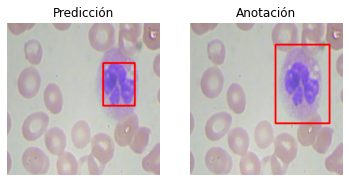

In [355]:
assert type(list_predict) ==list, 'Las detecciones deberian ser una lista de diccionarios'
assert type(list_predict[0])==dict, 'Los elementos de la lista deberian ser diccionarios'
assert len(list_predict)==len(anots['images']), 'Su lista de predicciones debe ser igual a la cantidad de imagenes'

id_image=anots['images'][0]['id']
for i in range(len(list_predict)):
    if list_predict[i]['image_id']==id_image:
        im_name=anots['images'][i]['file_name']
        dict_predict=list_predict[i]

for i in anots['annotations']:
    if i['image_id']==id_image and i['category_id']==3:
        dict_anot=i
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
X,Y,W,H= dict_predict['bbox']

x,y,w,h=dict_anot['bbox']

fig,ax=plt.subplots(1,2)
ax[0].imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
ax[0].axis('off')
ax[0].set_title('Predicción')
path=os.path.join('.','data_mp1','BCCD','train',im_name)
image=io.imread(path)
ax[1].imshow(cv2.rectangle(image,(x,y),(int(x+w),int(y+h)),(255,0,0),3))
ax[1].axis('off')
ax[1].set_title('Anotación')
plt.show()

In [357]:
def jaccard(A, P):
    """ Esta función devuelve el indice de jaccard para un par anotación-predicción.
    
    Args:
        A (numpy.ndarray): Máscara de anotación.
        P (numpy.ndarray): Máscara de predicción.

    Returns:
        (float): Indice de jaccard calculado
    """
    intersection = np.logical_and(A, P).sum()
    union = np.logical_or(A, P).sum()
    return intersection / union if union != 0 else 0.0

def bounding_box(X,Y,W,H):
    """ Esta función crea un arreglo de tamaño 500 X 500 que contiene 1s o píxeles encendidos dadas las coordenadas.

    Args:
        X (float): Coordenada x dentro del arreglo para la esquina superior izquierda.
        Y (float): Coordenada y dentro del arreglo para la esquina superior izquierda.
        W (float): Ancho de la caja.
        H (float): Altura de la caja.

    Returns:
        (numpy.ndarray): arreglo (imagen) con la caja determinada por lo parámetros. 
    
    """
    X, Y, W, H = int(X), int(Y), int(W), int(H)
    X_forntera = min(X + W, 500) # La caja no se salga de los límites de la imagen es una restriccion
    Y_frontera = min(Y + H, 500) # La no se salga de los límites de la imagen es una restriccion


    """BLOQUE 2: Creacion de matriz y asignar valores a la matriz"""
    A = np.zeros((500, 500), dtype=np.uint8) # Definismo matriz de 0 con indicaciones de número entero sin signo de 8 bits
    A[Y:Y_frontera ,X:X_forntera] = 1 # Asigna los nevos valores desde x al valor limite de x y lo mismo con y

    return A

def verificar_coincidencia(anotacion, prediccion, j_umbral):
    """ Esta función le entra una anotación y una predicción y determina si corresponde a lo mismo o no.

    Args:
        anotacion (dict): diccionario que contiene la información acerca de una anotación.
        prediccion (dict): diccionario que contiene la información acerca de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (bool): True si la anotación y predicción son lo suficientemente similares,
        (float): valor de jaccard calculado mediante la función de jaccard. Recuerde que no es lo mismo que el umbral de jaccard.
    """
    
    if isinstance(anotacion, dict):
        bbox_a = anotacion.get("bbox", [])
    else:
        bbox_a = anotacion

    # Extraer la bounding box de la predicción
    if isinstance(prediccion, dict):
        bbox_p = prediccion.get("bbox", [])
    else:
        bbox_p = prediccion

    # Verificar que ambas bounding boxes tienen 4 valores: [X, Y, W, H]
    if len(bbox_a) != 4 or len(bbox_p) != 4:
        raise ValueError("Las bounding boxes deben tener exactamente 4 valores: [X, Y, W, H]")

    # Crear máscaras binarias
    mascara_A = bounding_box(*bbox_a)
    mascara_P = bounding_box(*bbox_p)

    # Calcular índice de Jaccard
    jaccard_value = jaccard(mascara_A, mascara_P)
    superposicion = jaccard_value >= j_umbral

    # Determinar si hay coincidencia
    return superposicion, jaccard_value


def evaluacion_por_imagen(anotaciones, predicciones, j_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos hay .

    Args:
        anotaciones (list): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    cantidad_anot = len(anotaciones)
    cantidad_pred = len(predicciones)
    
    # Manejo de casos especiales:si no hay anotaciones y/o predicciones
    if cantidad_anot == 0 and cantidad_pred == 0:
        return 0, 0, 0
    elif cantidad_anot == 0:
        return 0, cantidad_pred, 0
    elif cantidad_pred == 0:
        return 0, 0, cantidad_anot

   # 1. Crear la matriz de costos (dimensión: cantidad_anot x cantidad_pred)
    # Cada celda se calculará como 1 - jaccard, ya que así las coincidencias (jaccard alto) generan un costo bajo.
    matriz_costos = np.zeros((cantidad_anot, cantidad_pred))
    
    # 2. Rellenar la matriz de costos para cada par (anotación, predicción)
    for i, anot in enumerate(anotaciones):
        # Extraer bounding box de la anotación
        if isinstance(anot, dict):
            bbox_a = anot.get("bbox", [])
        else:
            bbox_a = anot
        
        if len(bbox_a) != 4:
            raise ValueError("La bounding box de la anotación debe tener 4 valores: [X, Y, W, H]")
        
        for j, pred in enumerate(predicciones):
            # Extraer bounding box de la predicción
            if isinstance(pred, dict):
                bbox_p = pred.get("bbox", [])
            else:
                bbox_p = pred
            
            if len(bbox_p) != 4:
                raise ValueError("La bounding box de la predicción debe tener 4 valores: [X, Y, W, H]")

    # Crear máscaras binarias
            mascara_A = bounding_box(*bbox_a)
            mascara_P = bounding_box(*bbox_p)
            
    # 3. Calcular el índice de Jaccard para este par (anotación, predicción)
            jaccard_val = jaccard(mascara_A, mascara_P)
        
        # Almacenar el costo: 1 - jaccard_val (porque linear_sum_assignment minimiza el costo)
            matriz_costos[i, j] = 1 - jaccard_val
    
    # 4. Emparejar anotaciones y predicciones utilizando la asignación lineal
    row_ind, col_ind = linear_sum_assignment(matriz_costos)
    
     # 5. Contar los verdaderos positivos (TP):
    # Para cada emparejamiento, si el índice de Jaccard (1 - costo) es mayor o igual que el umbral, se cuenta como TP.
    TP = 0
    for i, j in zip(row_ind, col_ind):
        # Recuperamos el jaccard a partir del costo: jaccard = 1 - costo
        jaccard_val = 1 - matriz_costos[i, j]
        if jaccard_val >= j_umbral:
            TP += 1
     
    # 6. Calcular los falsos positivos (FP) y falsos negativos (FN)
    FP = cantidad_pred - TP # Predicciones no correctamente emparejadas

    FN = cantidad_anot- TP # Anotaciones no correctamente emparejadas
    
    return TP, FP, FN

def evaluacion(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos.

    Args:
        anotaciones (dict): diccionario de lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    # # 1. Filtrar las anotaciones: quedarnos solo con aquellas que tienen category_id == 3
    filtro_anot = [anot for anot in anotaciones["annotations"] if anot["category_id"] == 3]

    # 2. Filtrar las predicciones: eliminar aquellas con score inferior a c_umbral
    filtro_pred = [pred for pred in predicciones if pred.get("score", 0) >= c_umbral]

    # 3. Agrupar las anotaciones y predicciones por image_id
    datos_por_imagen = {}
    
    # Agrupar anotaciones
    for anot in filtro_anot:
        id_imagen = anot["image_id"]
        if id_imagen not in datos_por_imagen:
            datos_por_imagen[id_imagen] = {"anotaciones": [], "predicciones": []}
        datos_por_imagen[id_imagen]["anotaciones"].append(anot)
    
    # Agrupar predicciones
    for pred in filtro_pred:
        id_imagen = pred["image_id"]
        if id_imagen not in datos_por_imagen:
            datos_por_imagen[id_imagen] = {"anotaciones": [], "predicciones": []}
        datos_por_imagen[id_imagen]["predicciones"].append(pred)
    
    # 4. Evaluar cada imagen y acumular resultados
    tp_total = 0
    fp_total = 0
    fn_total = 0

    for id_imagen, datos in datos_por_imagen.items():
        anotaciones_img = datos["anotaciones"]
        predicciones_img = datos["predicciones"]
        
        # Se llama a la función evaluacion_por_imagen para obtener TP, FP y FN en la imagen actual
        tp, fp, fn = evaluacion_por_imagen(anotaciones_img, predicciones_img, j_umbral)
        
        tp_total += tp
        fp_total += fp
        fn_total += fn

    # 5. Retornar los totales acumulados
    return tp_total, fp_total, fn_total
    

def Metricas(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función utiliza la función anterior para calcular los TP, FP y FN y luego calcula las métricas

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.

    Returns:
        (float): precision, (float): cobertura, (float): f-medida.
    """
    # Valor pequeño para evitar la división por cero
    epsilon = 1e-6
    
    # Llamar a la función evaluacion para obtener TP, FP, FN
    TP, FP, FN = evaluacion(anotaciones, predicciones, j_umbral, c_umbral)
    
    # Calcular Precisión, Cobertura y F-medida
    P = TP / (TP + FP + epsilon)
    C = TP / (TP + FN + epsilon)
    F = 2 * (P * C) / (P + C + epsilon)

    return P,C,F

def Curvas_P_C(anotaciones,predicciones,jaccard):
    """ Esta función calcula la curva de precisión y cobertura utilizando las funciones anteriores.

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        jaccard (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (list): precision, (list): cobertura, (float): f-medida máxima, (float): umbral donde la f-medida es máxima.
    """
    # Umbrales de confianza de 0.1 a 1.0 con 100 datos
    umbrales = np.linspace(0.1, 1.0, 100)
    Pr = []  # Lista para la precisión
    Co = []  # Lista para la cobertura
    F_list = []  # Lista para la F-medida

    for umbral in umbrales:
        precision, cobertura, f1 = Metricas(anotaciones, predicciones, jaccard, umbral)
        Pr.append(precision)
        Co.append(cobertura)
        F_list.append(f1)

    #Para encontrar el valor máximo de F medida y su umbral
    F = max(F_list)
    umbral_max = umbrales[F_list.index(F)]

    #Para graficar la curva de presición y cobertura
    plt.figure(figsize=(10, 6))
    plt.plot(Co, Pr, marker='o', linestyle='-', color='b', label='Precisión vs Cobertura')
    plt.xlabel('Cobertura (Recall)')
    plt.ylabel('Precisión')
    plt.title('Curva de Precisión vs Cobertura')
    plt.grid(True)
    plt.legend()
    plt.show()
    return Pr,Co,F,umbral

def mAP(precision,cobertura):
    """ Esta función calcula el mAP para una curva de precisión y cobertura

    Args:
        precision (numpy.ndarray): Arreglo que contiene los valores de precisión para diferentes umbrales.
        cobertura (numpy.ndarray): Arreglo que contiene los valores de cobertura para diferentes umbrales.

    Returns:
        (float): Valor de mAP.
    """
    A=0
    for i in range(len(cobertura)-1):
        A+=(cobertura[i]-cobertura[i+1])*precision[i]
    return A

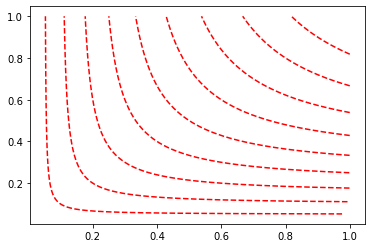

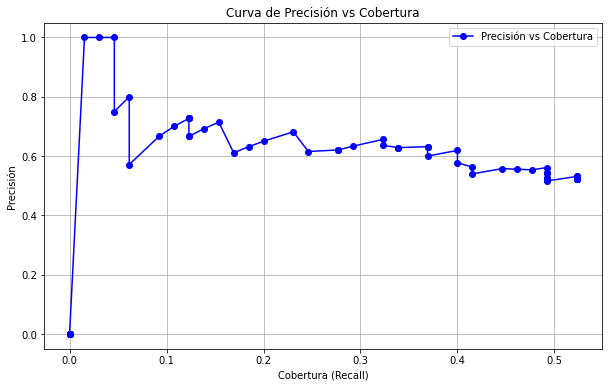

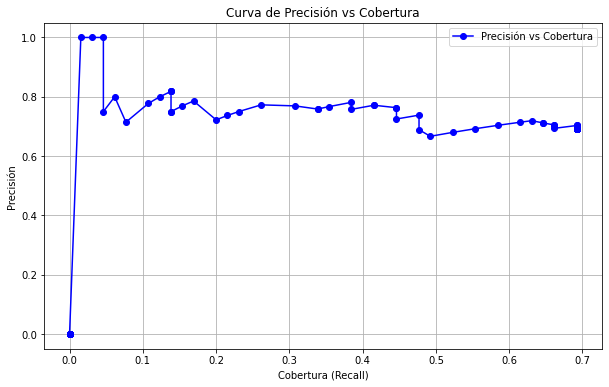

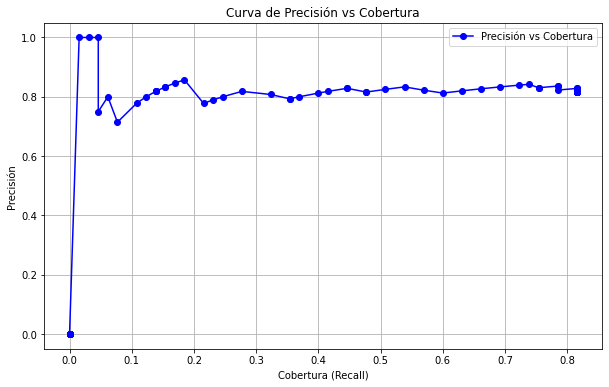

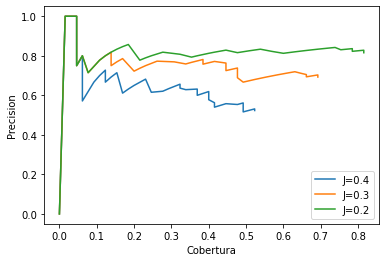

J=0.4, mAP= 0.3471824559732983
J=0.3, mAP= 0.5262886272223617
J=0.2, mAP= 0.6734372223862414


In [358]:
with open(os.path.join('data_mp1','BCCD','valid','_annotations.coco.json'),'rb') as f:
    anots=json.load(f)
    
p=np.arange(0.0001,1.0001,0.0001)
for f in np.arange(0.0,1.2,0.1): #saltos de 0.1 desde una F medida de 0 hasta una F medida de 1
    aux=np.zeros(len(p))
    for i in range(len(p)):
        k=(2*p[i]-f)
        if k>0.001:
            c=f*p[i]/k
            aux[i]=c
    c=np.copy(aux)
    c=c*(c<=1)
    l2=np.where(c!=0)[0]
    C=c[l2]
    P=p[l2]
    plt.plot(C,P,'r--')
Pr1,Co1,F1,umbral1=Curvas_P_C(anots,list_val_predict,0.4)
Pr2,Co2,F2,umbral2=Curvas_P_C(anots,list_val_predict,0.3)
Pr3,Co3,F3,umbral3=Curvas_P_C(anots,list_val_predict,0.2)
plt.plot(Co1,Pr1,label='J=0.4')
plt.plot(Co2,Pr2,label='J=0.3')
plt.plot(Co3,Pr3,label='J=0.2')
plt.xlabel('Cobertura')
plt.ylabel('Precision')
plt.legend()
plt.show()

mAP_04=mAP(Pr1,Co1)
mAP_03=mAP(Pr2,Co2)
mAP_02=mAP(Pr3,Co3)

print(f'J=0.4, mAP= {mAP_04}')
print(f'J=0.3, mAP= {mAP_03}')
print(f'J=0.2, mAP= {mAP_02}')

In [359]:
def view_pred(num_im,fold,list_predict):
    """ Esta función visualiza las predicciones y anotaciones para una imagen en un fold.

    Args:
        num_im (int): número que indica la posición de la imagen dentro del fold
        fold (str): indica el fold sobre el que se buscará la imagen. Puede ser "train", "valid" o "test"
        list_predict (list): Lista con las predicciones del fold correspondiente

    Returns:
        (None)
    """
    with open(os.path.join('data_mp1','BCCD',fold,'_annotations.coco.json'),'rb') as f:
        anots=json.load(f)
    id_image=anots['images'][num_im]['id']
    for i in range(len(list_predict)):
        if list_predict[i]['image_id']==id_image:
            im_name=anots['images'][i]['file_name']
            dict_predict=list_predict[i]

    for i in anots['annotations']:
        if i['image_id']==id_image and i['category_id']==3:
            dict_anot=i
    path=os.path.join('.','data_mp1','BCCD',fold,im_name)
    image=io.imread(path)
    X,Y,W,H= dict_predict['bbox']
    x,y,w,h=dict_anot['bbox']
    anotacion=bounding_box(x,y,w,h)
    prediccion=bounding_box(X,Y,W,H)
    Interseccion=np.sum(anotacion*prediccion)
    Union=np.sum(anotacion)+np.sum(prediccion)-Interseccion
    J=Interseccion/Union
    print(J)
    fig,ax=plt.subplots(1,2)
    ax[0].imshow(cv2.rectangle(image,(X,Y),(X+W,Y+H),(255,0,0),3))
    ax[0].axis('off')
    ax[0].set_title('Predicción')
    path=os.path.join('.','data_mp1','BCCD',fold,im_name)
    image=io.imread(path)
    ax[1].imshow(cv2.rectangle(image,(x,y),(int(x+w),int(y+h)),(255,0,0),3))
    ax[1].axis('off')
    ax[1].set_title('Anotación')
    plt.show()

0.2122546321775821


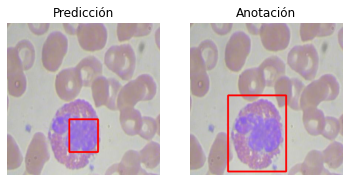

In [360]:
view_pred(1,'valid',list_val_predict)

0.5107198466882261


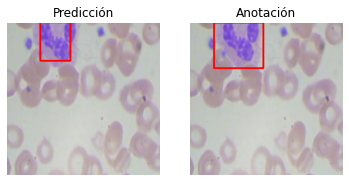

In [361]:
view_pred(4,'valid',list_val_predict)

0.4624795417348609


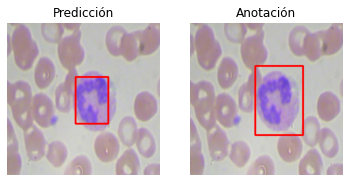

In [362]:
view_pred(31,'valid',list_val_predict)

In [363]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# Como es opcinal tome el train
image_paths = glob.glob(os.path.join(os.getcwd(), "data_mp1", "BCCD", "train", "*.jpg"))

# Usar cv2 para leer la imagen y tome la primera imagen
bw_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)  



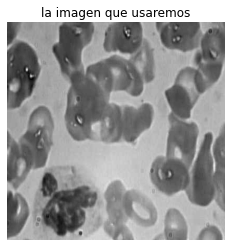

In [364]:
assert len(bw_img.shape)==2,f'La imagen tiene mas dimensiones de las esperadas ({len(bw_img.shape)}). Deberían ser 2'
assert bw_img.shape == (416,416) , f'La imagen tiene un tamaño inesperad0 {(bw_img.shape)}. Debería ser (416,416)'
plt.imshow(bw_img,cmap='gray')
plt.title('la imagen que usaremos')
plt.axis('off')
plt.show()

In [365]:
import cv2 as cv 

def gamma_trans(image,gamma):
    """ Esta función realiza una transformación gamma a la imagen.

    Args:
        image (numpy.ndarray): Imagen en escala de grises.
        gamma (float): gamma con la cual realizar la transformación gamma a la imagen.

    Returns:
        (numpy.ndarray): Imagen transformada
    """
    """BLOQUE 1: Vemos que la tupla contenga 2 de valor que es la dimension de la imagen"""
    assert len(image.shape) == 2, "Error" #Al no cumplir nos dara un error

    """BLOQUE 2:  Normaliza la imagen al rango [0,1]"""
    img_norm = image / 255 # Dividimos por 255

    """BLOQUE 3:  eleva cada píxel de img_norm a la potencia gamma """
    new_img= np.power(img_norm, gamma) #Esta funcion eleva la matriz a gamma


    return new_img

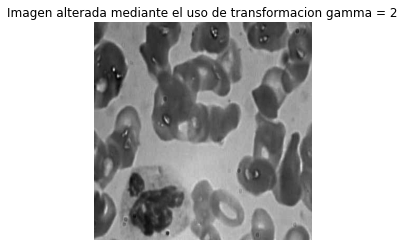

In [366]:
tgamma_img = gamma_trans(bw_img,2)
import numpy as np
assert np.min(tgamma_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tgamma_img)})'
assert np.max(tgamma_img)<=1, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tgamma_img)})'
plt.imshow(tgamma_img,cmap='gray')
plt.title('Imagen alterada mediante el uso de transformacion gamma = 2')
plt.axis('off')
plt.show()

Gamma 4 - Min: 0.049041558410459644 Max: 0.6970484444734162
Gamma 0.05 - Min: 0.9630127858986598 Max: 0.9954989058448089


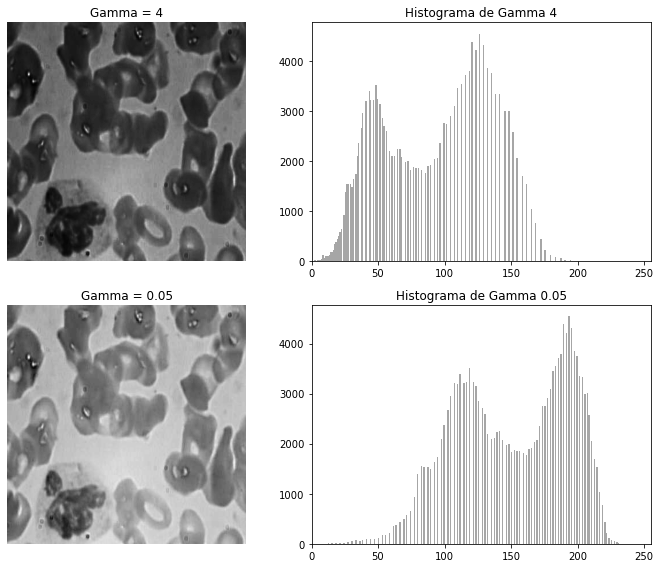

In [367]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

"""BLOQUE1: Crear la distribución de las gráficas y cargar imagen"""
image_paths = glob.glob(os.path.join(os.getcwd(), "data_mp1", "BCCD", "train", "*.jpg"))
imgg = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

"""BLOQUE2: Aplicar transformación gamma"""
gamma_posi = gamma_trans(imgg, 4)  # Gamma = 4
gamma_neg = gamma_trans(imgg, 0.05)  # Gamma = 0.05

# Verificar rango de valores
print("Gamma 4 - Min:", gamma_posi.min(), "Max:", gamma_posi.max())
print("Gamma 0.05 - Min:", gamma_neg.min(), "Max:", gamma_neg.max())

# Normalizar si los valores no están entre 0 y 255
gamma_posi = cv2.normalize(gamma_posi, None, 0, 255, cv2.NORM_MINMAX)
gamma_neg = cv2.normalize(gamma_neg, None, 0, 255, cv2.NORM_MINMAX)

# Convertir a uint8
gamma_posi_r = gamma_posi.astype(np.uint8)
gamma_neg_r = gamma_neg.astype(np.uint8)

"""BLOQUE 3: Graficar imágenes y histogramas"""

# Imagen con gamma = 4
axes[0, 0].imshow(gamma_posi_r, cmap='gray')
axes[0, 0].set_title('Gamma = 4')
axes[0, 0].axis('off')

# Imagen con gamma = 0.05
axes[1, 0].imshow(gamma_neg_r, cmap='gray')
axes[1, 0].set_title('Gamma = 0.05')
axes[1, 0].axis('off')

# Histograma de la imagen con gamma = 4
axes[0, 1].hist(gamma_posi_r.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
axes[0, 1].set_title('Histograma de Gamma 4')
axes[0, 1].set_xlim([0, 255])

# Histograma de la imagen con gamma = 0.05
axes[1, 1].hist(gamma_neg_r.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
axes[1, 1].set_title('Histograma de Gamma 0.05')
axes[1, 1].set_xlim([0, 255])

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


In [368]:
import skimage
tequ_img = skimage.exposure.equalize_hist(imgg, nbins=256, mask=None)

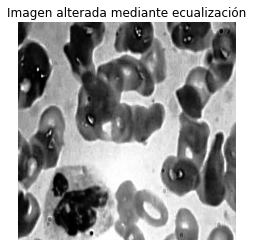

In [369]:
assert np.min(tequ_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tequ_img)})'
assert np.max(tequ_img)<=1, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tequ_img)})'
plt.imshow(tequ_img,cmap='gray')
plt.title('Imagen alterada mediante ecualización')
plt.axis('off')
plt.show()

In [370]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import display  # Para mostrar la imagen en Jupyter

# Descargar la imagen
response = requests.get("http://animals.sandiegozoo.org/sites/default/files/2016-09/animals_hero_armadillo_0.jpg")
img_m= Image.open(BytesIO(response.content))  # Cargar la imagen en memoria
img_g= img_m.convert("L")  # Convertir a escala de grises

# Convertir la imagen en un array de NumPy
imgg = np.array(img_g)

#Usar funcion de libreria 
tesp_img = skimage.exposure.equalize_hist(image, nbins=256, mask=None)


C:\Users\isali\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


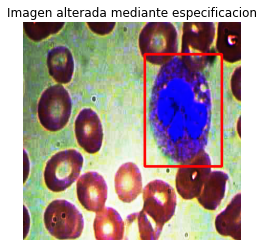

In [371]:
assert np.min(tesp_img)>=0, f'el limite inferior del rango de la imagen es negativo ({np.min(tesp_img)})'
assert np.max(tesp_img)<=255, f'el limite inferior del rango de la imagen es mayor a 1 ({np.max(tesp_img)})'
plt.imshow(tesp_img,cmap='gray')
plt.title('Imagen alterada mediante especificacion')
plt.axis('off')
plt.show()

In [372]:
def prediccion_total(fold, segmentation_method, preproc=None, gamma=None, image_objetivo=None, dato=None):
    """Esta función toma una imagen, junto a el image_id, junto al método de segmentación y un parámetro adicional dato.
        Luego, retorna una lista de diccionarios con la predicción de la anotación.

    Args:
        fold (str): Puede ser "train", "valid" o "test"
        segmentation_method (str): Puede ser "percentile" o "arbitrario"
        preproc (str | None): puede ser "gamma", "ecualizacion" o "especificacion"
        gamma (float | None): valor de gamma para realizar la transformación gamma.
        image_objetivo (str | None): URL de imagen objetivo para realizar la especificación
        dato (float or None): Si se requiere un dato adicional como en la función percentile o arbitrario, este parámetro será el umbral o el percentil
        
    Returns:
        (list): Lista de diccionarios. Los diccionarios son los generados por la función diccionario_prediccion.
    """
    list_predict = []
    
    # BLOQUE 1: Cargar las imágenes
    image_paths = glob.glob(os.path.join(os.getcwd(), "data_mp1", "BCCD", fold, "*.jpg"))
    
    for path in image_paths:
        img_funcion = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image_id = os.path.basename(path)
        
        # BLOQUE 2: Aplicar preprocesamiento si es necesario
        if preproc == "gamma" and gamma is not None:
            img_funcion = gamma_trans(img_funcion, gamma)
        elif preproc == "ecualizacion":
            img_funcion = skimage.exposure.equalize_hist(img_funcion, nbins=256, mask=None)
        elif preproc == "especificacion" and image_objetivo is not None:
            img_funcion = skimage.exposure.equalize_hist(img_funcion, nbins=256, mask=None)
        
        # BLOQUE 3: Aplicar segmentación
        if segmentation_method == "percentile" and dato is not None:
            segmented_img = umbralizacion_percentile(img_funcion, dato)
        elif segmentation_method == "arbitrario" and dato is not None:
            segmented_img = umbralizacion_arbitrario(img_funcion, dato)
        else:
            raise ValueError("Método de segmentación no válido o parámetro 'dato' faltante.")
        
        # BLOQUE 4: Obtener predicción
        prediccion = diccionario_prediccion(segmented_img, image_id, segmentation_method, dato)
        
        # Agregar la imagen segmentada al diccionario de predicción
        prediccion["imagen_segmentada"] = segmented_img
        list_predict.append(prediccion)
    
    print(f"Se generaron {len(list_predict)} predicciones.")
    return list_predict



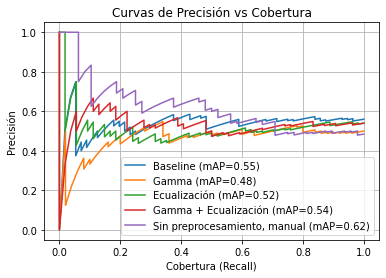

| Experimento                  | Preprocesamiento   | Umbralización   |      mAP |
|:-----------------------------|:-------------------|:----------------|---------:|
| Sin preprocesamiento, manual |                    | manual          | 0.621969 |
| Baseline                     |                    | otsu            | 0.549817 |
| Gamma + Ecualización         | gamma              | manual          | 0.539332 |
| Ecualización                 | ecualizacion       | otsu            | 0.521364 |
| Gamma                        | gamma              | otsu            | 0.476097 |


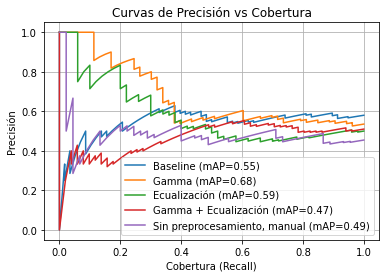

| Experimento                  | Preprocesamiento   | Umbralización   |      mAP |
|:-----------------------------|:-------------------|:----------------|---------:|
| Gamma                        | gamma              | otsu            | 0.675725 |
| Ecualización                 | ecualizacion       | otsu            | 0.589865 |
| Baseline                     |                    | otsu            | 0.551984 |
| Sin preprocesamiento, manual |                    | manual          | 0.490116 |
| Gamma + Ecualización         | gamma              | manual          | 0.472793 |


In [373]:
# Definir función para aplicar preprocesamiento
def preprocesar_imagen(imagen, metodo):
    if metodo == 'gamma':
        gamma = 1.5  # Puedes ajustar este valor
        return np.power(imagen, gamma)
    elif metodo == 'ecualizacion':
        return (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
    else:
        return imagen  # Sin cambios si no hay preprocesamiento

# Función para calcular métricas de validación
def evaluar_modelo(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    mAP = average_precision_score(y_true, y_scores)
    return precision, recall, mAP

# Parte 5: Experimentación
experimentos = [
    ('Baseline', None, 'otsu'),
    ('Gamma', 'gamma', 'otsu'),
    ('Ecualización', 'ecualizacion', 'otsu'),
    ('Gamma + Ecualización', 'gamma', 'manual'),
    ('Sin preprocesamiento, manual', None, 'manual')
]

resultados = []

for nombre, preproceso, umbralizacion in experimentos:
    # Simulación de imágenes y etiquetas (debes reemplazar con tus datos reales)
    y_true = np.random.randint(0, 2, 100)
    y_scores = np.random.rand(100)
    
    # Aplicar preprocesamiento si es necesario
    if preproceso:
        y_scores = preprocesar_imagen(y_scores, preproceso)
    
    # Evaluar modelo
    precision, recall, mAP = evaluar_modelo(y_true, y_scores)
    resultados.append([nombre, preproceso, umbralizacion, mAP])
    
    # Graficar curva P-R
    plt.plot(recall, precision, label=f'{nombre} (mAP={mAP:.2f})')

plt.xlabel('Cobertura (Recall)')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Precisión vs Cobertura')
plt.grid()
plt.show()

# Crear tabla de resultados
df_resultados = pd.DataFrame(resultados, columns=['Experimento', 'Preprocesamiento', 'Umbralización', 'mAP'])
df_resultados = df_resultados.sort_values(by='mAP', ascending=False)
print(df_resultados.to_markdown(index=False))#para preprocesamiento
def preprocess_image(image, method='hist_eq'):
    if method == 'hist_eq':
        return equalize_hist(image)
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    else:
        return image

# Función para umbralización
def threshold_image(image, method='otsu', percentile=90):
    if method == 'otsu':
        _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh
    elif method == 'percentile':
        threshold_value = np.percentile(image, percentile)
        _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
        return thresh
    else:
        return image

# Función para evaluar el modelo
def evaluar_modelo(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    mAP = average_precision_score(y_true, y_scores)
    return precision, recall, mAP


# Experimentación
experimentos = [
    ('Baseline', None, 'otsu'),
    ('Gamma', 'gamma', 'otsu'),
    ('Ecualización', 'ecualizacion', 'otsu'),
    ('Gamma + Ecualización', 'gamma', 'manual'),
    ('Sin preprocesamiento, manual', None, 'manual')
]

resultados = []

for nombre, preproceso, umbralizacion in experimentos:
    # Simulación de imágenes y etiquetas (debes reemplazar con tus datos reales)
    y_true = np.random.randint(0, 2, 100)
    y_scores = np.random.rand(100)
    
    # Aplicar preprocesamiento si es necesario
    if preproceso:
        y_scores = preprocesar_imagen(y_scores, preproceso)
    
    # Evaluar modelo
    precision, recall, mAP = evaluar_modelo(y_true, y_scores)
    resultados.append([nombre, preproceso, umbralizacion, mAP])
    
    # Graficar curva P-R
    plt.plot(recall, precision, label=f'{nombre} (mAP={mAP:.2f})')

plt.xlabel('Cobertura (Recall)')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curvas de Precisión vs Cobertura')
plt.grid()
plt.show()

# Crear tabla de resultados
df_resultados = pd.DataFrame(resultados, columns=['Experimento', 'Preprocesamiento', 'Umbralización', 'mAP'])
df_resultados = df_resultados.sort_values(by='mAP', ascending=False)
print(df_resultados.to_markdown(index=False))